In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

#torch.random.manual_seed(1)

# Genera punti casuali (città)
# densità delle città (0 < x <= 1)
city_density = 1
grid_size = 20
cities_grid = torch.randint( int( 1 / city_density )+1, size = ( grid_size, grid_size ), dtype=torch.int )

# ripulisce la griglia, solo se il valore è = 1 è considerata "città"
cities_grid[ cities_grid > 1 ] = 0

# calcola il numero di città
num_cities = int(torch.sum(cities_grid == 1))
print(f"Numero di città: {num_cities}")

Numero di città: 219


## Definizione distanza tra le città

In [3]:
# definisco la distanza di Manhattan
def distanza_manhattan(p1, p2):
  return np.abs(p1[0] - p2[0]) + np.abs(p1[1] - p2[1])

# definisco la distanza Euclidea
def distanza_euclidea(p1, p2):
  return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Crea una matrice delle distanze basata sulla griglia (1 rappresenta le città)
def crea_matrice_distanze(cities_grid, method="M"):
    city_positions = torch.argwhere(cities_grid == 1)
    num_cities = city_positions.shape[0]
    distances = torch.zeros((num_cities, num_cities), dtype=torch.int)
    for i in range(num_cities):
        for j in range(num_cities):
            if(method == "M"):
              distances[i, j] = distanza_manhattan(city_positions[i], city_positions[j])
            if(method == "E"):
              distances[i, j] = distanza_euclidea(city_positions[i], city_positions[j])
    return distances

distances = crea_matrice_distanze(cities_grid, "M")

# Algoritmo Genetico

In [4]:
# Funzione di fitness (lunghezza totale del tour)
def fitness(tour):
  return torch.sum(distances[tour[:-1], tour[1:]])

# Crossover
def crossover():
    offset = 1
    for i in range(0, population_size-1, 2):
        parent1 = population[i].clone()
        parent2 = population[i+1].clone()
        figlio1 = torch.tensor([-1]*len(parent1), dtype=torch.int)

        cross_point = np.random.randint(offset, int(num_cities/2))
        cross_start = cross_point
        cross_end =  len(parent1) - cross_point

        figlio1[cross_start : cross_end] = parent1[cross_start : cross_end]

        parent2_indices = torch.tensor(list(p2 not in figlio1 for p2 in parent2)).nonzero(as_tuple=True)[0].unsqueeze(1)
        figlio1_indices = (figlio1 == -1).nonzero(as_tuple=True)[0].unsqueeze(1)

        for i in range(0, len(parent2_indices)):
            figlio1[int(figlio1_indices[i])] = parent2[int(parent2_indices[i])]

        population[i] = figlio1

# Mutazione: swap di due elementi del vettore in modo causale
def mutation():
  for i in range( int( population_size * mut_porz ), population_size):
     idx1, idx2 = np.random.choice(num_cities, 2, replace=False)
     idx1_value = population[i, idx1].clone()
     idx2_value = population[i, idx2].clone()
     population[i, idx1] = idx2_value
     population[i, idx2] = idx1_value

# di debug per controllare città duplicate
def has_cities_duplicate(tour):
  unique_cities, _ = torch.unique(tour, return_counts=True)
  return unique_cities.shape[0] != tour.shape[0]

# Ciclo generativo

Ordine del miglior tour: 191, 91, 97, 208, 175, 207, 174, 190, 173, 145, 87, 68, 161, 45, 74, 118, 101, 112, 75, 88, 95, 92, 135, 103, 146, 28, 182, 81, 53, 73, 216, 179, 205, 170, 166, 201, 59, 48, 24, 38, 20, 56, 108, 143, 54, 93, 96, 22, 44, 76, 127, 183, 199, 134, 111, 171, 152, 35, 33, 65, 30, 162, 184, 144, 169, 156, 128, 194, 157, 158, 193, 218, 187, 197, 136, 110, 119, 32, 94, 159, 185, 189, 202, 133, 77, 70, 120, 126, 106, 82, 86, 34, 186, 198, 204, 206, 142, 140, 116, 122, 114, 14, 10, 46, 7, 17, 11, 85, 37, 66, 69, 58, 3, 84, 57, 100, 9, 149, 52, 71, 41, 61, 98, 196, 141, 43, 113, 200, 165, 148, 50, 78, 203, 138, 115, 125, 123, 72, 40, 5, 8, 181, 49, 219, 36, 67, 42, 83, 39, 60, 160, 26, 29, 23, 25, 107, 167, 217, 80, 16, 31, 19, 117, 12, 15, 1, 21, 209, 150, 176, 188, 163, 214, 178, 137, 102, 27, 18, 79, 51, 62, 172, 104, 180, 131, 129, 177, 168, 192, 213, 90, 155, 4, 6, 151, 124, 47, 99, 211, 195, 55, 64, 63, 132, 121, 164, 147, 154, 2, 105, 109, 130, 210, 215, 139, 13, 15

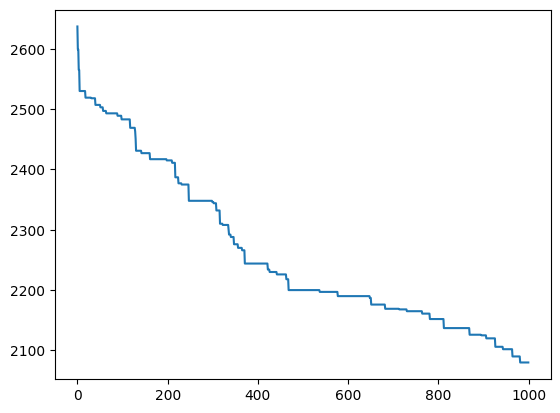

In [13]:
# Popoplazione iniziale generata casualmente
population_size = 300
# Numero di iterazioni
num_generazioni = 1000
# Porzioni di popolazione mutare
mut_porz = 0.1

#torch.random.manual_seed(18)
# Genera la popolazione casualmente
population = torch.arange(num_cities).repeat(population_size, 1)
for i in range(population_size):
    torch.randperm(num_cities, out=population[i])

#population = torch.cat((population, torch.tensor([2, 1, 6, 3, 0, 5, 4]).view(1, num_cities)), 0)

fitmin_array=torch.tensor([0]*num_generazioni) # Array che memorizza il fitness minimo ad ogni generazione

for gen in range(num_generazioni):
    fitness_values = torch.tensor([fitness(tour) for tour in population])
    sorted_indices = torch.argsort(fitness_values)
    population = population[sorted_indices]
    #print(population)
    fitmin_array[gen] = fitness_values.min()
    # crossover e mutazioni vengono fatte fino alla penultima iterazione
    if gen != num_generazioni-1:
        crossover()
        mutation()

# Estrai il miglior tour
miglior_tour = population[0]

# Stampa l'ordine delle città nel miglior tour
print(f"Ordine del miglior tour: {', '.join(str(int(x+1)) for x in miglior_tour)}")

# Calcola la lunghezza totale del tour
lunghezza_totale = fitness(miglior_tour)
print(f"Lunghezza totale del tour: {lunghezza_totale:.4f}")

# Stampa la griglia con le città e plotta l'andamento del minimo della fitness
#print(cities_grid)
n=np.arange(0,len(fitmin_array))
plt.plot(n,fitmin_array)

In [ ]:
seq = list(range(0, num_cities, 1))
#print(seq)

cities = [0] * num_cities

import random

for i in range(0, num_cities):
    cities[i] = random.choice(seq)
    seq.remove(cities[i])

print(cities)

# Solo Crossover

Ordine del miglior tour: 10, 46, 55, 160, 38, 23, 17, 114, 213, 192, 206, 133, 103, 177, 183, 203, 136, 144, 191, 81, 87, 19, 109, 212, 70, 21, 100, 77, 31, 178, 216, 193, 42, 156, 9, 106, 174, 158, 150, 166, 75, 68, 43, 65, 208, 90, 179, 169, 201, 5, 189, 45, 4, 152, 104, 92, 26, 22, 173, 85, 219, 16, 35, 121, 197, 64, 107, 99, 78, 210, 135, 149, 6, 62, 110, 146, 211, 164, 118, 71, 207, 125, 111, 112, 44, 34, 7, 198, 115, 148, 12, 101, 20, 147, 139, 131, 180, 60, 53, 14, 13, 200, 184, 214, 205, 161, 204, 140, 72, 82, 8, 61, 24, 51, 3, 199, 73, 57, 153, 218, 95, 138, 47, 27, 41, 33, 63, 130, 50, 86, 25, 155, 29, 93, 54, 83, 76, 116, 196, 97, 176, 170, 188, 165, 30, 89, 58, 48, 126, 88, 1, 190, 91, 69, 105, 117, 79, 120, 40, 123, 67, 167, 11, 37, 36, 66, 39, 128, 129, 124, 15, 141, 162, 96, 102, 145, 108, 127, 181, 142, 143, 163, 32, 185, 151, 168, 215, 59, 182, 134, 119, 202, 122, 113, 49, 28, 74, 171, 194, 195, 94, 2, 217, 157, 209, 175, 18, 56, 159, 84, 187, 172, 186, 80, 98, 52, 154

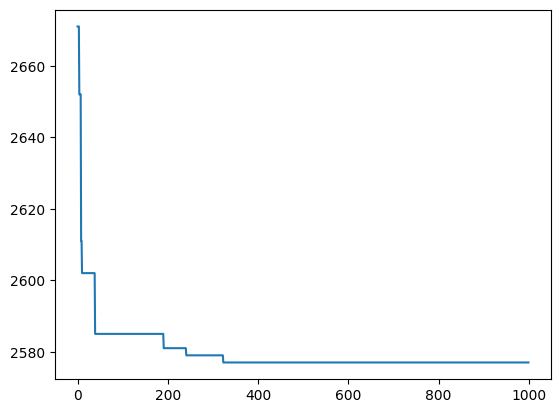

In [10]:
print(f"Ordine del miglior tour: {', '.join(str(int(x+1)) for x in miglior_tour)}")

# Calcola la lunghezza totale del tour
lunghezza_totale = fitness(miglior_tour)
print(f"Lunghezza totale del tour: {lunghezza_totale:.4f}")

# Stampa la griglia con le città e plotta l'andamento del minimo della fitness
n=np.arange(0,len(fitmin_array))
plt.plot(n,fitmin_array)

# Solo Mutazioni

Ordine del miglior tour: 57, 10, 81, 77, 38, 18, 15, 97, 70, 113, 120, 177, 76, 181, 182, 4, 194, 178, 34, 72, 118, 173, 121, 67, 33, 218, 52, 29, 39, 13, 1, 163, 132, 3, 46, 152, 199, 196, 175, 48, 17, 36, 109, 55, 206, 127, 95, 205, 164, 211, 86, 162, 124, 111, 61, 160, 16, 9, 197, 190, 94, 139, 219, 165, 45, 188, 147, 79, 85, 59, 64, 138, 151, 99, 78, 58, 68, 198, 179, 146, 149, 189, 145, 136, 93, 65, 5, 141, 69, 183, 210, 49, 47, 21, 129, 117, 166, 184, 185, 214, 50, 51, 44, 176, 170, 103, 92, 142, 74, 2, 102, 96, 14, 91, 125, 187, 200, 8, 60, 11, 161, 119, 123, 213, 12, 104, 204, 27, 192, 116, 37, 53, 26, 41, 172, 156, 56, 167, 90, 207, 100, 180, 110, 108, 88, 135, 154, 216, 203, 40, 208, 32, 63, 54, 75, 62, 168, 84, 71, 169, 101, 35, 122, 23, 80, 128, 83, 31, 28, 201, 212, 157, 73, 195, 148, 133, 43, 174, 131, 209, 171, 144, 89, 114, 153, 19, 82, 150, 215, 115, 6, 112, 66, 107, 126, 191, 24, 98, 87, 134, 202, 42, 193, 30, 20, 7, 137, 130, 158, 22, 25, 217, 186, 143, 155, 105, 159

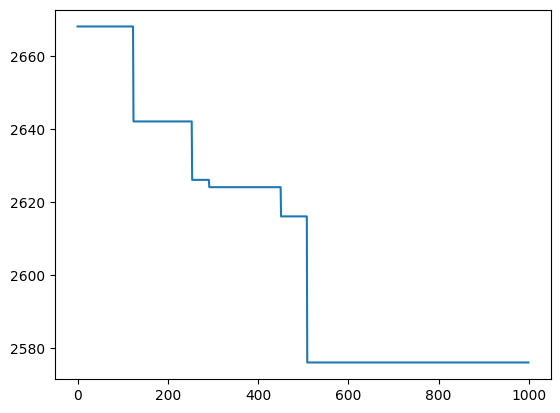

In [12]:
print(f"Ordine del miglior tour: {', '.join(str(int(x+1)) for x in miglior_tour)}")

# Calcola la lunghezza totale del tour
lunghezza_totale = fitness(miglior_tour)
print(f"Lunghezza totale del tour: {lunghezza_totale:.4f}")

# Stampa la griglia con le città e plotta l'andamento del minimo della fitness
n=np.arange(0,len(fitmin_array))
plt.plot(n,fitmin_array)